### Biblioteki

In [1]:
using Images
using PlotlyJS
using Colors, ColorVectorSpace, FixedPointNumbers, Statistics
using Interact
using Distances, Plots
using BenchmarkTools

WebIO._IJuliaInit()

# Przygotowanie Danych

### Wczytanie pliku Image0026-rgb.tif

In [2]:
# wczytanie pliku TIFF przy użyciu biblioteki Images.jl
img26 = load("dataset/rgb/FISH_Brachy/Image0026-rgb.tif");

In [3]:
dump(img26[rand(1:end)])

RGB{N0f8}
  r: N0f8
    i: UInt8 0x00
  g: N0f8
    i: UInt8 0x00
  b: N0f8
    i: UInt8 0x10


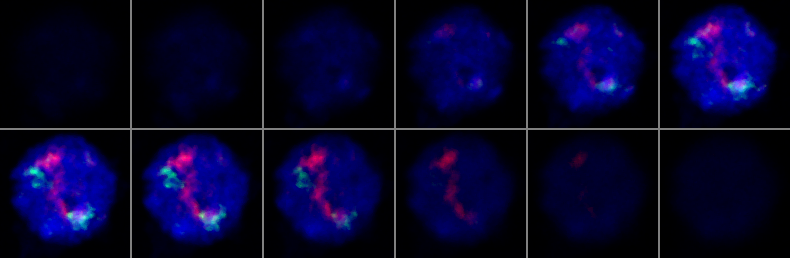

In [4]:
mosaicview(img26; fillvalue=0.5, npad=2, ncol=6, rowmajor=true)

### Wczytanie plików Experiment-392

In [5]:
# wczytanie ścieżek do plików
file_red = "dataset/rgb/Centr_tel Brachy/Experiment-392.czi - C=r.tif"
file_green = "dataset/rgb/Centr_tel Brachy/Experiment-392.czi - C=g.tif"
file_blue = "dataset/rgb/Centr_tel Brachy/Experiment-392.czi - C=b.tif"

# wczytanie plików TIFF przy użyciu biblioteki Images
tif_red=load(file_red);
tif_green=load(file_green);
tif_blue=load(file_blue);

### Funkcja generująca współrzędne dla układu 3D (3D Array)

In [6]:
function get_coords(img)
    y_size, x_size, z_size = size(img)

    z_list = zeros(0)

    for i in 1:z_size
        append!(z_list, fill(i ,y_size * x_size))
    end

    x_list = zeros(0)
    for i in 1:x_size
        append!(x_list, fill(i ,y_size))
    end  

    append!(x_list, repeat(x_list,z_size-1))

    y_list = collect(1:y_size)
    append!(y_list, repeat(y_list,z_size * x_size-1));
    
    return hcat(y_list,x_list,z_list)
end

get_coords (generic function with 1 method)

### Połączenie współrzędnych, kolorów i rozmiarów pikseli

In [7]:
# wydobycie współrzędnych
coords_matrix = get_coords(img26);

# spłaszczenie danych do postaci Wektora (Vector)
img26_flat = vec(img26)

# przekształcenie typu kolorów z N0f8 na Float64
img26_flat = RGB{Float64}.(img26_flat)

# utworzenie kolumny rozmiarów pikseli (same jedynki)
ones_array = ones(length(img26_flat))

# połączenie danych
img26_arr=hcat(coords_matrix, red.(img26_flat), green.(img26_flat), 
    blue.(img26_flat), ones_array);

Połączenie współrzędnych z kolorami i rozmiarem dla exp392

In [8]:
coords_matrix = get_coords(tif_red)

# flatten 3d array into 1d array
tif_red_flat = vec(tif_red)
tif_green_flat = vec(tif_green)
tif_blue_flat = vec(tif_blue)


# tif_flat = RGB{Float64}.(tif_red_flat*4,tif_green_flat*4,tif_blue_flat*4)

# # # creating column of ones with size as number of pixels
ones_array = ones(length(tif_red_flat))

# # # connecting 1d arrays like columns into 2d array
# # #img26_arr=hcat(y_list,x_list,z_list, img26_flat, ones_array);
tif_arr=hcat(coords_matrix, Float64.(tif_red_flat*4), Float64.(tif_green_flat*4), Float64.(tif_blue_flat*4), ones_array);

### Usuwanie czarnego tła

In [9]:
function clear_black_bg(tif_arr, threshold)
    tif_arr = tif_arr[vec(mapslices(col -> (col[4] .> threshold)
                | (col[5] .> threshold)
                | (col[6] .> threshold), 
            tif_arr, dims = 2)), :]
    return tif_arr
end

# odfiltrowanie pliku img26
println("Rozmiar danych przed usunięciem tła: "
    ,size(img26_arr))

img26_arr_cl=clear_black_bg(img26_arr,0.315);

println("Rozmiar danych przed usunięciem tła: "
    ,size(img26_arr_cl))

Rozmiar danych przed usunięciem tła: (199680, 7)
Rozmiar danych przed usunięciem tła: (41562, 7)


In [10]:
tif_arr_cl=clear_black_bg(tif_arr,0.392156862);

### funkcje pomocnicze

### Obliczanie centroidu - Julia

In [11]:
function get_centroid(array_2d)
    length = size(array_2d, 1)
    sum_y = sum(array_2d[:,1])
    sum_x = sum(array_2d[:,2])
    sum_z = sum(array_2d[:,3])
    
    return hcat(sum_y/length, sum_x/length, sum_z/length, 
        mean(array_2d[:,4]), mean(array_2d[:,5]), 
        mean(array_2d[:,6]), length)
end

get_centroid (generic function with 1 method)

### Obliczanie mediany - Julia

In [12]:
function get_median(arr)
    # zapisanie rozmiaru zbioru
    length = size(arr, 1)
    
    # zwracanie median kolumn zbioru
    return hcat(median(arr[:,1]), median(arr[:,2]), 
        median(arr[:,3]), median(arr[:,4]), 
        median(arr[:,5]), median(arr[:,6]), length)
end

get_median (generic function with 1 method)

### Funkcja znajdująca sąsiadów - Julia

In [13]:
function get_neighbours(tif_arr, pixel, radius, zradius, color_diff)
    
    n = tif_arr[vec(mapslices(col -> 
                (col[1] .<= pixel[1]+radius) & (col[1] .>= pixel[1]-radius)
                & (col[2] .<= pixel[2]+radius) & (col[2] .>= pixel[2]-radius)
                & (col[3] .<= pixel[3]+zradius) & (col[3] .>= pixel[3]-zradius)
                & (col[4] .<= pixel[4]+color_diff) & (col[4] .>= pixel[4]-color_diff)
                & (col[5] .<= pixel[5]+color_diff) & (col[5] .>= pixel[5]-color_diff)
                & (col[6] .<= pixel[6]+color_diff) & (col[6] .>= pixel[6]-color_diff), 
                tif_arr, dims = 2)), :]
    return n
end

get_neighbours (generic function with 1 method)

In [14]:
function get_neighbours2(tif_arr, pixel, radius, zradius)
    
    n = tif_arr[vec(mapslices(col -> (col[1] .<= pixel[1]+radius) & (col[1] .>= pixel[1]-radius)
                                    & (col[2] .<= pixel[2]+radius) & (col[2] .>= pixel[2]-radius)
                                    & (col[3] .<= pixel[3]+zradius) & (col[3] .>= pixel[3]-zradius), 
                                    tif_arr, dims = 2)), :]
    return n
end

get_neighbours2 (generic function with 1 method)

In [15]:
function get_neighbours_by_color(tif_arr, pixel, color_diff)
    
    n = tif_arr[vec(mapslices(col -> (col[4] .<= pixel[4]+color_diff) & (col[4] .>= pixel[4]-color_diff)
                                    & (col[5] .<= pixel[5]+color_diff) & (col[5] .>= pixel[5]-color_diff)
                                    & (col[6] .<= pixel[6]+color_diff) & (col[6] .>= pixel[6]-color_diff), 
                                    tif_arr, dims = 2)), :]
    return n
end

get_neighbours_by_color (generic function with 1 method)

### Usuwanie podzbioru - Julia

In [16]:
function remove_neighbours(tif_arr, n)
    tif_arr=tif_arr[vec(mapslices(row -> !(row in eachrow(n)), 
                tif_arr, dims = 2)),:]
    return tif_arr
end

remove_neighbours (generic function with 1 method)

### Metoda Centroidów - wariant I - Julia

In [17]:
function centroid_method(tif_arr,radius,zradius,color_diff)
    # utworzenie pustego zbioru centrodów
    centroids = Array{Float64}(undef, 0, 7)

    # zapętlanie procesu, aż zbiór danych będzie pusty
    while size(tif_arr, 1)>0

        # losowanie startowego piksela
        pixel = tif_arr[rand(1:end), :] 
        
        # utworzenie zbioru sąsiadów
        n=get_neighbours(tif_arr, pixel, radius, zradius, color_diff)
        
        # dodanie centroidu do zbioru centroidów
        centroid = get_centroid(n)

        # obliczanie centroidu ze zbioru sąsiadów
        centroids = [centroids; centroid]

        # usuwanie zbioru sąsiadów ze zbioru danych
        tif_arr=tif_arr[vec(mapslices(row -> !(row in eachrow(n)), tif_arr, dims = 2)),:]
    end
    
    return centroids
end

centroid_method (generic function with 1 method)

### Centroid Method II - różnica koloru - z usuwaniem

In [18]:
function centroid_method2(tif_arr,radius,zradius,color_diff)
    # defining empty matrix where centroids will be stored
    centroids = Array{Float64}(undef, 0, 7)

    # looping thorugh tif_arrlicated array until it's empty
    while size(tif_arr, 1)>0

        # assign starting point to random pixel
        pixel = tif_arr[rand(1:end), :] 

        n=get_neighbours2(tif_arr, pixel, radius, zradius)
        
        # deleting neighbours from tif_arrlicated array
        tif_arr=tif_arr[vec(mapslices(row -> !(row in eachrow(n)), tif_arr, dims = 2)),:]
        
        n=get_neighbours_by_color(n, pixel,color_diff)
        
        # calculating centroid vector from array of neighbours
        centroid = get_centroid(n)

        # adding centroid to centroids matrix
        centroids = [centroids; centroid]

    end
    println(size(centroids))
    return centroids
end

centroid_method2 (generic function with 1 method)

### Centroid Method III - bez różnicy koloru + nie ma outlierów

In [19]:
function centroid_method3(tif_arr,radius,zradius)
    # defining empty matrix where centroids will be stored
    centroids = Array{Float64}(undef, 0, 7)

    # looping thorugh tif_arrlicated array until it's empty
    while size(tif_arr, 1)>0

        # assign starting point to random pixel
        pixel = tif_arr[rand(1:end), :] 

        n=get_neighbours2(tif_arr, pixel, radius, zradius)
        
        # deleting neighbours from tif_arrlicated array
        tif_arr=tif_arr[vec(mapslices(row -> !(row in eachrow(n)), tif_arr, dims = 2)),:]
        
        # calculating centroid vector from array of neighbours
        centroid = get_centroid(n)

        # adding centroid to centroids matrix
        centroids = [centroids; centroid]

    end
    println(size(centroids))
    return centroids
end

centroid_method3 (generic function with 1 method)

### Obliczanie medoidu - Julia

In [20]:
function get_medoid(n)
    # tworzenie macierzy wzajemnych odległości
    distMatrix=pairwise(Euclidean(),n[:,1:6],dims=1)
    # wybieranie piksela o najmniejszej sumie odległości
    medoid=n[argmin(sum(distMatrix,dims=2))[1],:]
    
    # dodanie rozmiaru grupy
    medoid=reshape(medoid, 1, length(medoid))
    medoid[7]=size(n,1)
    
    return medoid
end

get_medoid (generic function with 1 method)

### Medoid Method I - różnica koloru - bez usuwania

In [21]:
function medoid_method(tif_arr,radius,zradius,color_diff)
# defining empty matrix where centroids will be stored
    medoids = Array{Float64}(undef, 0, 7)

    # looping thorugh tif_arrlicated array until it's empty
    while size(tif_arr, 1)>0

        # assign starting point to random pixel
        pixel = tif_arr[rand(1:end), :] 

        # creating matrix of neighbours
        n=get_neighbours(tif_arr, pixel, radius, zradius, color_diff)

        medoid=get_medoid(n)

        medoids=[medoids;medoid]
        # deleting neighbours from tif_arrlicated array
        tif_arr=tif_arr[vec(mapslices(row -> !(row in eachrow(n)), tif_arr, dims = 2)),:]

    end
    println(size(medoids))
    return medoids
end

medoid_method (generic function with 1 method)

### Medoid Method II - różnica koloru - z usuwaniem

In [22]:
function medoid_method2(tif_arr,radius,zradius,color_diff)
# defining empty matrix where centroids will be stored
    medoids = Array{Float64}(undef, 0, 7)

    # looping thorugh tif_arrlicated array until it's empty
    while size(tif_arr, 1)>0

        # assign starting point to random pixel
        pixel = tif_arr[rand(1:end), :] 

        # creating matrix of neighbours
        n=get_neighbours2(tif_arr, pixel, radius, zradius)
        
        # deleting neighbours from tif_arrlicated array
        tif_arr=tif_arr[vec(mapslices(row -> !(row in eachrow(n)), tif_arr, dims = 2)),:]
        
        n=get_neighbours_by_color(n, pixel, color_diff)

        medoid=get_medoid(n)
        medoids=[medoids;medoid]
        
    end
    println(size(medoids))
    return medoids
end

medoid_method2 (generic function with 1 method)

### Medoid Method III - bez różnicy koloru + nie ma outlierów

In [23]:
function medoid_method3(tif_arr,radius,zradius)
# defining empty matrix where centroids will be stored
    medoids = Array{Float64}(undef, 0, 7)

    # looping thorugh tif_arrlicated array until it's empty
    while size(tif_arr, 1)>0

        # assign starting point to random pixel
        pixel = tif_arr[rand(1:end), :] 

        # creating matrix of neighbours
        n=get_neighbours2(tif_arr, pixel, radius, zradius)
        
        # deleting neighbours from tif_arrlicated array
        tif_arr=tif_arr[vec(mapslices(row -> !(row in eachrow(n)), tif_arr, dims = 2)),:]

        medoid=get_medoid(n)
        medoids=[medoids;medoid]
        
    end
    println(size(medoids))
    return medoids
end

medoid_method3 (generic function with 1 method)

### Median Method I - różnica koloru - bez usuwania

In [24]:
function median_method(tif_arr,radius,zradius,color_diff)
# defining empty matrix where centroids will be stored
    medians = Array{Float64}(undef, 0, 7)

    # looping thorugh tif_arrlicated array until it's empty
    while size(tif_arr, 1)>0

        # assign starting point to random pixel
        pixel = tif_arr[rand(1:end), :] 

        # creating matrix of neighbours
        n=get_neighbours(tif_arr, pixel, radius, zradius, color_diff)

        # adding centroid to centroids matrix

        median=get_median(n)
        medians=[medians;median]
        # deleting neighbours from tif_arrlicated array
        tif_arr=tif_arr[vec(mapslices(row -> !(row in eachrow(n)), tif_arr, dims = 2)),:]

    end
    println(size(medians))
    return medians
end

median_method (generic function with 1 method)

### Median Method II - różnica koloru - z usuwaniem

In [25]:
function median_method2(tif_arr,radius,zradius,color_diff)
# defining empty matrix where centroids will be stored
    medians = Array{Float64}(undef, 0, 7)

    # looping thorugh tif_arrlicated array until it's empty
    while size(tif_arr, 1)>0

        # assign starting point to random pixel
        pixel = tif_arr[rand(1:end), :] 

        # creating matrix of neighbours
        n=get_neighbours2(tif_arr, pixel, radius, zradius)
        
        # deleting neighbours from tif_arrlicated array
        tif_arr=tif_arr[vec(mapslices(row -> !(row in eachrow(n)), tif_arr, dims = 2)),:]
        
        n=get_neighbours_by_color(n, pixel, color_diff)

        median=get_median(n)
        medians=[medians;median]
        
    end
    println(size(medians))
    return medians
end

median_method2 (generic function with 1 method)

### Median Method III - bez różnicy koloru + nie ma outlierów

In [26]:
function median_method3(tif_arr,radius,zradius)
# defining empty matrix where centroids will be stored
    medians = Array{Float64}(undef, 0, 7)

    # looping thorugh tif_arrlicated array until it's empty
    while size(tif_arr, 1)>0

        # assign starting point to random pixel
        pixel = tif_arr[rand(1:end), :] 

        # creating matrix of neighbours
        n=get_neighbours2(tif_arr, pixel, radius, zradius)
        
        # deleting neighbours from tif_arrlicated array
        tif_arr=tif_arr[vec(mapslices(row -> !(row in eachrow(n)), tif_arr, dims = 2)),:]

        median=get_median(n)
        medians=[medians;median]
        
    end
    println(size(medians))
    return medians
end

median_method3 (generic function with 1 method)

In [27]:
function plotly_vis(matrix, smin, smax)
    # przygotowanie kolorów do wczytania do wykresu
    color_arr= RGB{Float64}.(matrix[:,4],matrix[:,5],matrix[:,6])
    return PlotlyJS.plot(PlotlyJS.scatter3d(
            ;x=matrix[:,2], 
            y=matrix[:,1], 
            z=matrix[:,3],
            text=matrix[:,7],
            customdata=color_arr,
            type="scatter3d",
            mode="markers",
            marker=attr(
                sizemode="area",
                size=matrix[:,7],
                color=color_arr,
                sizeref=(maximum(matrix[:,7])) / (smax ^ 2),
                sizemin=smin,
                opacity=1,
                line=attr(width=0)
            ),

            hovertemplate="<br>x:%{x}<br>y:%{y}<br>z:%{z}"
                *"<br>color: %{customdata}<br>size: %{text}"
        )
    )
end

plotly_vis (generic function with 1 method)

### Widżet Julia

In [28]:
function tif_reduction_widget(tif_arr)
    bg_threshold = slider(0.1:0.005:.6, label = "bg_threshold")
    radius = slider(1:15, label = "zradius")
    zradius = slider(1:5, label = "zradius")
    color_diff = slider(0:0.01:.3, label = "color_diff")
    smin = slider(0:20, label = "smin")
    smax = slider(40:60, label = "smax")
    method = dropdown(OrderedDict(
            "centroid method" => "centroid_method", 
            "centroid method 2" => "centroid_method2", 
            "centroid method 3" => "centroid_method3",
            "medoid method" => "medoid_method", 
            "medoid method 2" => "medoid_method2", 
            "medoid method 3" => "medoid_method3", 
            "median method" => "median_method", 
            "median method 2" => "median_method2", 
            "median method 3" => "median_method3")
            ,label="method")
    update = button("compute")
    
    output= Observable{Any}((undef, 0, 0))
    plt=Plots.plot()
    Interact.@map (&update; tif_arr=clear_black_bg(tif_arr, bg_threshold[]);
        if  method[] == "centroid_method"
            output[] = centroid_method(tif_arr,radius[],zradius[],color_diff[])
        elseif method[] == "centroid_method2"
            output[] = centroid_method2(tif_arr,radius[],zradius[],color_diff[])
        elseif method[] == "centroid_method3"
            output[] = centroid_method3(tif_arr,radius[],zradius[])
        elseif method[] == "medoid_method"
            output[] = medoid_method(tif_arr,radius[],zradius[],color_diff[])
        elseif method[] == "medoid_method2"
            output[] = medoid_method2(tif_arr,radius[],zradius[],color_diff[])
        elseif method[] == "medoid_method3"
            output[] = medoid_method3(tif_arr,radius[],zradius[])
        elseif method[] == "median_method"
            output[] = median_method(tif_arr,radius[],zradius[],color_diff[])
        elseif method[] == "median_method2"
            output[] = median_method2(tif_arr,radius[],zradius[],color_diff[])
        elseif method[] == "median_method3"
            output[] = median_method3(tif_arr,radius[],zradius[])end)
    plt = Interact.@map plotly_vis(&output,&smin,&smax)
    wdg = Widget(["bg_threshold" => bg_threshold,"radius" => radius,
                  "zradius" => zradius, "color_diff" => color_diff, 
                  "update" => update, "smin" => smin, "smax" => smax, 
                  "method"=>method], output = output);
    @layout! wdg hbox(plt, vbox(:bg_threshold,:radius, :zradius,
            :color_diff, pad(1em,:method), :update, :smin, :smax))
end

tif_reduction_widget (generic function with 1 method)

In [29]:
tif_reduction_widget(img26_arr)

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Observable{PlotlyJS.SyncPlot} with 0 listeners. Value:
PlotlyJS.SyncPlot(data: [
  "scatter3d with fields customdata, hovertemplate, marker, mode, text, type, x, y, and z"
]

layout: "layout with fields margin and template"

, Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}(:id => "plot-0dc002cf-0fbb-40fe-921a-d23addabeb0b")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("_toImage" => (Observable{Dict{Any, Any}} with 1 listeners. Value:
Dict{Any, Any}(), nothing), "hover" => (Observable{Dict{Any, Any}} with 0 listeners. Value:
Dict{Any, Any}(), nothing), "selected" => (Observable{Dict{Any, Any}} with 0 listeners. Value:
Dict{Any, Any}(), nothing), "__gd_contents" => (Observable{Any} with 0 listeners. Value:
Dict{Any, Any}(), nothing), "click" => (Observable{Dict{Any, Any}} with 0 listeners. Value:
Dict{Any, Any}(), nothing), "image" => (Observable{String} with 1 listeners. Value:
"", nothing), "__get_gd_contents" => (Observable{String} with 1 listeners. Value:
"", nothing), "_downloadImage" => (Observable{Dict{Any, Any}} with 1 listeners. Value:
Dict{Any, Any}(), nothing), "relayout" => (Observable{Dict{Any, Any}} with 0 listeners. Value:
Dict{Any, Any}(), nothing), "_commands" => (Observable{Any} with 1 listeners. Value:
Any[], nothing)…), Set{String}(), nothing, Asset[Asset("js", "Plotly", "C:\\Users\\lukasz\\.julia\\artifacts\\77a3f27e7a726685591b11ef3174d43a9a974c9a\\plotly.min.js"), Asset("js", nothing, "C:\\Users\\lukasz\\.julia\\packages\\PlotlyJS\\4jzLr\\src\\..\\assets\\plotly_webio.bundle.js")], Dict{Any, Any}("_toImage" => Any[WebIO.JSString("(function (options){return this.Plotly.toImage(this.plotElem,options).then((function (data){return WebIO.setval({\"name\":\"image\",\"scope\":\"5762304146816688093\",\"id\":\"6679704661418894953\",\"type\":\"observable\"},data)}))})")], "__get_gd_contents" => Any[WebIO.JSString("(function (prop){prop==\"data\" ? (WebIO.setval({\"name\":\"__gd_contents\",\"scope\":\"5762304146816688093\",\"id\":\"12780980049264054067\",\"type\":\"observable\"},this.plotElem.data)) : undefined; return prop==\"layout\" ? (WebIO.setval({\"name\":\"__gd_contents\",\"scope\":\"5762304146816688093\",\"id\":\"12780980049264054067\",\"type\":\"observable\"},this.plotElem.layout)) : undefined})")], "_downloadImage" => Any[WebIO.JSString("(function (options){return this.Plotly.downloadImage(this.plotElem,options)})")], "_commands" => Any[WebIO.JSString("(function (args){var fn=args.shift(); var elem=this.plotElem; var Plotly=this.Plotly; args.unshift(elem); return Plotly[fn].apply(this,args)})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000000467a4330, Task (runnable) @0x00000000467a4330), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = ((function (Plotly,PlotlyWebIO){PlotlyWebIO.init(WebIO); var gd=this.dom.querySelector(\"#plot-0dc002cf-0fbb-40fe-921a-d23addabeb0b\"); this.plotElem=gd; this.Plotly=Plotly; (window.Blink!==undefined) ? (gd.style.width=\"100%\", gd.style.height=\"100vh\", gd.style.marginLeft=\"0%\", gd.style.marginTop=\"0vh\") : undefined; window.onresize=(function (){return Plotly.Plots.resize(gd)}); Plotly.newPlot(gd,[{\"x\":[57.15375722543352,53.28642590286426,49.197037037037035,83.1645813282002,79.24724602203182,48.57243816254417,39.35609334485739,94.83571428571429,63.76485461441214,68.51698113207547,45.605947955390334,60.434065934065934,18.894545454545455,92.62260127931769,62.51538461538462,93.1576923076923,37.65060240963855,80.02199661590525,49.71084337349398,74.73934837092732,54.23412698412698,31.11520737327189,24.342,95.93939393939394,82.72779922779922,39.36279069767442,69.24469589816124,74.99033816425121,74.7296511627907,97.7629179331307,86.22340425531915,83.3563829787234,25.849884526558892,67.87671232876713,38.41312741312741,61.195402298850574,69.21428571428

(96, 7)


### Pomiary z podrozdziału Metody redukcji danych

test metod w wariancie II

In [ ]:
size(img26_arr_cl)

In [ ]:
@time centroid_method2(img26_arr_cl,1,1,0.0393);

In [ ]:
@time medoid_method2(img26_arr_cl,1,1,0.0393);

In [ ]:
@time median_method2(img26_arr_cl,1,1,0.0393);

test metod w wariancie III

In [ ]:
@time centroid_method3(img26_arr_cl,1,1);

In [ ]:
@time medoid_method3(img26_arr_cl,1,1);

In [ ]:
@time median_method3(img26_arr_cl,1,1);

inne testy

In [ ]:
@benchmark centroid_method2($img26_arr_cl,1,1,0.0393)

In [ ]:
@btime centroid_method2(img26_arr_cl,1,1,0.0393)

In [ ]:
@benchmark centroid_method($img26_arr,5,1,0.0393)

In [ ]:
@benchmark medoid_method($img26_arr,10,1,0.0393)

In [ ]:
@benchmark get_centroid($img26_arr)

### Analiza porównówcza Testy

In [ ]:
centroid_method(img26_arr_cl,5,1,0.0393)

In [ ]:
@time centroid_method(img26_arr_cl,5,1,0.0393)
@time centroid_method(img26_arr_cl,4,1,0.0393)
@time centroid_method(img26_arr_cl,3,1,0.0393)

In [ ]:
@time centroid_method(img26_arr_cl,5,1,01965)
@time centroid_method(img26_arr_cl,4,1,01965)
@time centroid_method(img26_arr_cl,3,1,01965)

In [ ]:
@time medoid_method(img26_arr_cl,5,1,0.0393)
@time medoid_method(img26_arr_cl,4,1,0.0393)
@time medoid_method(img26_arr_cl,3,1,0.0393)

In [ ]:
@time medoid_method(img26_arr_cl,5,1,01965)
@time medoid_method(img26_arr_cl,4,1,01965)
@time medoid_method(img26_arr_cl,3,1,01965)

In [ ]:
@time median_method(img26_arr_cl,5,1,0.0393)
@time median_method(img26_arr_cl,4,1,0.0393)
@time median_method(img26_arr_cl,3,1,0.0393)

In [ ]:
@time median_method(img26_arr_cl,5,1,01965)
@time median_method(img26_arr_cl,4,1,01965)
@time median_method(img26_arr_cl,3,1,01965)

II

In [ ]:
@time centroid_method2(img26_arr_cl,3,1,0.0393)
@time centroid_method2(img26_arr_cl,2,1,0.0393)
@time centroid_method2(img26_arr_cl,1,1,0.0393)

In [ ]:
@time centroid_method2(img26_arr_cl,3,1,0.00393)
@time centroid_method2(img26_arr_cl,2,1,0.00393)
@time centroid_method2(img26_arr_cl,1,1,0.00393)

In [ ]:
@time medoid_method2(img26_arr_cl,3,1,0.0393)
@time medoid_method2(img26_arr_cl,2,1,0.0393)
@time medoid_method2(img26_arr_cl,1,1,0.0393)
@time medoid_method2(img26_arr_cl,3,1,0.00393)
@time medoid_method2(img26_arr_cl,2,1,0.00393)
@time medoid_method2(img26_arr_cl,1,1,0.00393)

In [ ]:
@time median_method2(img26_arr_cl,3,1,0.0393)
@time median_method2(img26_arr_cl,2,1,0.0393)
@time median_method2(img26_arr_cl,1,1,0.0393)
@time median_method2(img26_arr_cl,3,1,0.00393)
@time median_method2(img26_arr_cl,2,1,0.00393)
@time median_method2(img26_arr_cl,1,1,0.00393)

III

In [ ]:
@time centroid_method3(img26_arr_cl,3,1,0.0393)
@time centroid_method3(img26_arr_cl,2,1,0.0393)
@time centroid_method3(img26_arr_cl,1,1,0.0393)
@time centroid_method3(img26_arr_cl,3,1,0.00393)
@time centroid_method3(img26_arr_cl,2,1,0.00393)
@time centroid_method3(img26_arr_cl,1,1,0.00393)

In [ ]:
@time medoid_method3(img26_arr_cl,3,1,0.0393)
@time medoid_method3(img26_arr_cl,2,1,0.0393)
@time medoid_method3(img26_arr_cl,1,1,0.0393)
@time medoid_method3(img26_arr_cl,3,1,0.00393)
@time medoid_method3(img26_arr_cl,2,1,0.00393)
@time medoid_method3(img26_arr_cl,1,1,0.00393)

In [ ]:
@timeit median_method3(img26_arr_cl,3,1,0.0393)
@timeit median_method3(img26_arr_cl,2,1,0.0393)
@timeit median_method3(img26_arr_cl,1,1,0.0393)
@timeit median_method3(img26_arr_cl,3,1,0.00393)
@timeit median_method3(img26_arr_cl,2,1,0.00393)
@timeit median_method3(img26_arr_cl,1,1,0.00393)